# Project 5: Speech Emotion Recognition

**Type:** Audio Processing | **Level:** Advanced

Recognize emotions from speech audio using deep learning.

**Model:** CNN on Spectrograms

**Dataset:** [RAVDESS Dataset](https://www.kaggle.com/datasets/uwrfkaggle/ravdess-emotional-speech-audio)

## 1. Setup & Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Librosa version: {librosa.__version__}")

Libraries imported successfully!
TensorFlow version: 2.20.0
Librosa version: 0.11.0


## 2. Load Data

In [ ]:
# Load the dataset
audio_dir = '../data/speech_recognition/Crema/'

# Get all audio files
audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]

print(f"Total audio files: {len(audio_files)}")
print(f"\nSample filenames:")
for f in audio_files[:5]:
    print(f"  {f}")

# Parse filenames to extract emotion labels
# Format: ActorID_Sentence_Emotion_Intensity.wav
# Emotions: ANG (Angry), DIS (Disgust), FEA (Fear), HAP (Happy), NEU (Neutral), SAD (Sad)

emotion_mapping = {
    'ANG': 'angry',
    'DIS': 'disgust',
    'FEA': 'fear',
    'HAP': 'happy',
    'NEU': 'neutral',
    'SAD': 'sad'
}

# Create dataframe
data = []
for filename in audio_files:
    parts = filename.split('_')
    emotion_code = parts[2]
    emotion = emotion_mapping.get(emotion_code, 'unknown')
    data.append({
        'filename': filename,
        'emotion': emotion,
        'path': os.path.join(audio_dir, filename)
    })

df = pd.DataFrame(data)

print(f"\nDataset shape: {df.shape}")
print(f"\nEmotion distribution:")
print(df['emotion'].value_counts())
print(f"\nDataframe preview:")
df.head()

Total audio files: 7442

Sample filenames:
  1022_ITS_ANG_XX.wav
  1037_ITS_ANG_XX.wav
  1060_ITS_NEU_XX.wav
  1075_ITS_NEU_XX.wav
  1073_IOM_DIS_XX.wav

Dataset shape: (7442, 3)

Emotion distribution:
emotion
angry      1271
disgust    1271
sad        1271
fear       1271
happy      1271
neutral    1087
Name: count, dtype: int64

Dataframe preview:


,filename,emotion,path
0,1022_ITS_ANG_XX.wav,angry,../data/speech_recognition/Crema/1022_ITS_ANG_...
1,1037_ITS_ANG_XX.wav,angry,../data/speech_recognition/Crema/1037_ITS_ANG_...
2,1060_ITS_NEU_XX.wav,neutral,../data/speech_recognition/Crema/1060_ITS_NEU_...
3,1075_ITS_NEU_XX.wav,neutral,../data/speech_recognition/Crema/1075_ITS_NEU_...
4,1073_IOM_DIS_XX.wav,disgust,../data/speech_recognition/Crema/1073_IOM_DIS_...


## 3. Exploratory Data Analysis

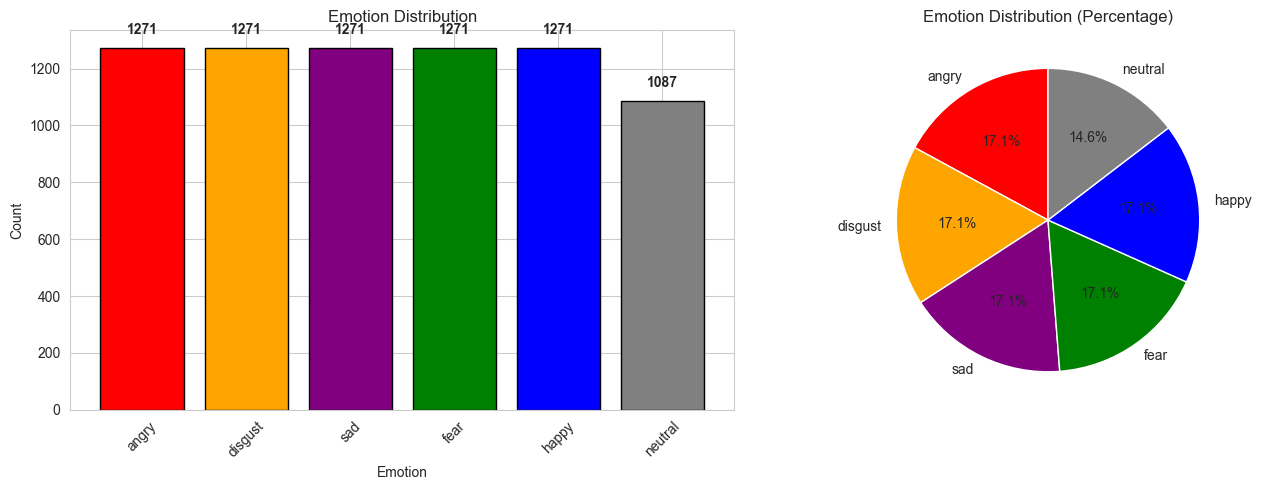


Sample Audio Analysis:


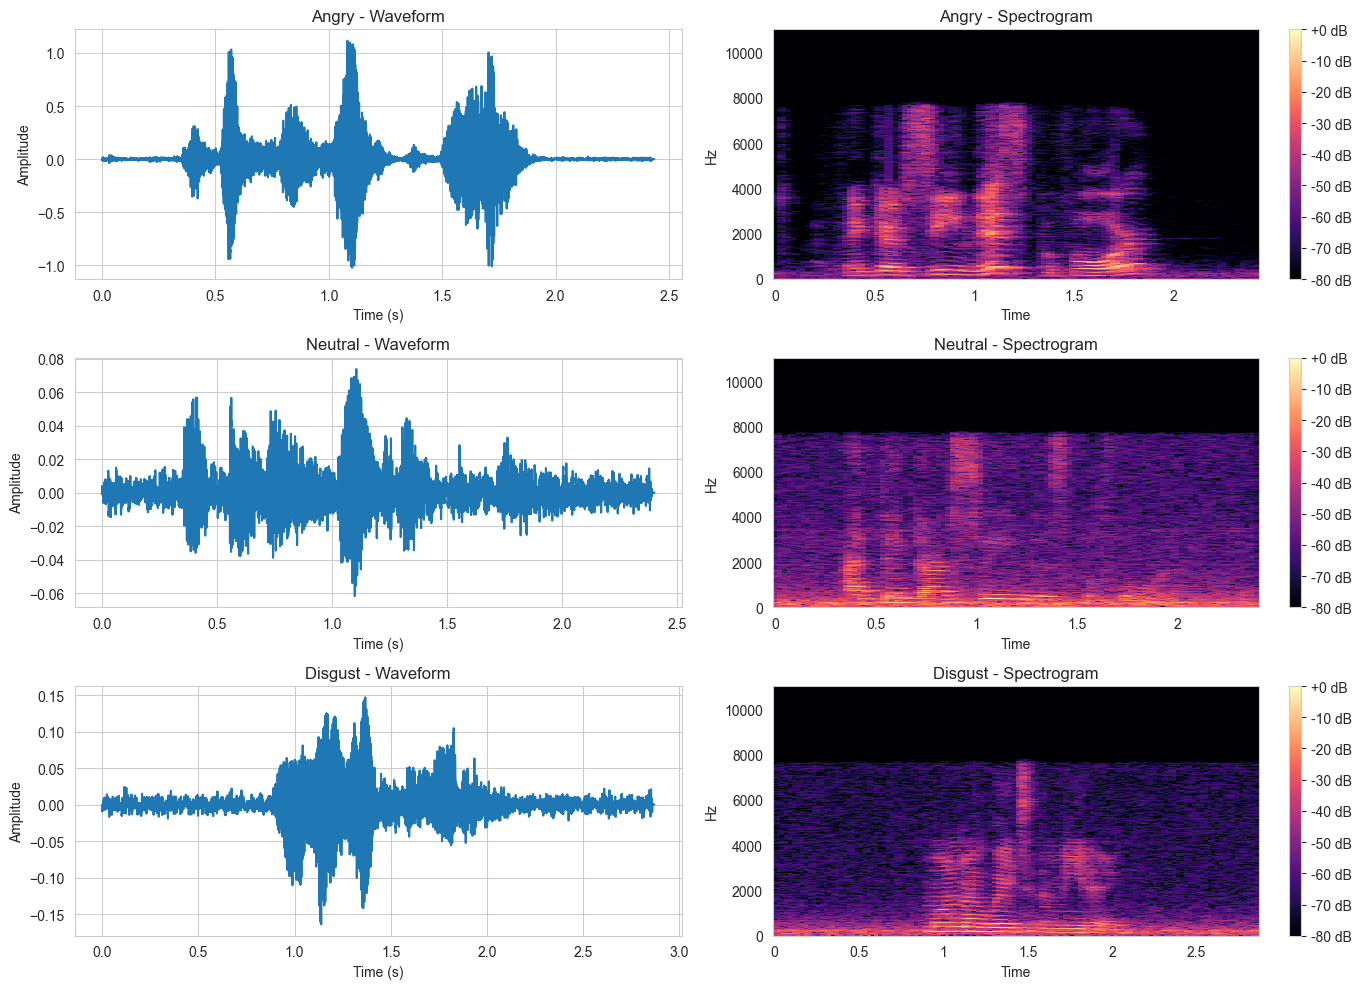

In [ ]:
# Visualize emotion distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
emotion_counts = df['emotion'].value_counts()
axes[0].bar(emotion_counts.index, emotion_counts.values, 
            color=['red', 'orange', 'purple', 'green', 'blue', 'gray'], 
            edgecolor='black')
axes[0].set_title('Emotion Distribution')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(emotion_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%',
            colors=['red', 'orange', 'purple', 'green', 'blue', 'gray'], startangle=90)
axes[1].set_title('Emotion Distribution (Percentage)')

plt.tight_layout()
plt.show()

# Visualize sample audio waveforms and spectrograms
print("\nSample Audio Analysis:")
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

sample_emotions = df['emotion'].unique()[:3]
for i, emotion in enumerate(sample_emotions):
    sample = df[df['emotion'] == emotion].iloc[0]
    audio_path = sample['path']
    
    # Load audio
    y, sr = librosa.load(audio_path, duration=3)
    
    # Waveform
    axes[i, 0].plot(np.linspace(0, len(y)/sr, len(y)), y)
    axes[i, 0].set_title(f'{emotion.capitalize()} - Waveform')
    axes[i, 0].set_xlabel('Time (s)')
    axes[i, 0].set_ylabel('Amplitude')
    
    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[i, 1])
    axes[i, 1].set_title(f'{emotion.capitalize()} - Spectrogram')
    fig.colorbar(img, ax=axes[i, 1], format='%+2.0f dB')

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [ ]:
# Extract features from audio files using MFCCs
# MFCC is more commonly used for speech emotion recognition
print("Extracting MFCC features (this may take a few minutes)...")

def extract_mfcc_features(audio_path, n_mfcc=40, max_len=130):
    """
    Extract MFCC features from audio file with fixed dimensions
    """
    # Load audio with fixed duration
    y, sr = librosa.load(audio_path, duration=3)
    
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    # Pad or truncate to fixed length
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

# Use more samples for better accuracy
n_samples = 3000
df_subset = df.sample(n=min(n_samples, len(df)), random_state=42).reset_index(drop=True)

features = []
labels = []

for idx, row in df_subset.iterrows():
    if idx % 200 == 0:
        print(f"Processing {idx}/{len(df_subset)}...")
    
    try:
        feat = extract_mfcc_features(row['path'])
        features.append(feat)
        labels.append(row['emotion'])
    except Exception as e:
        print(f"Error processing {row['filename']}: {e}")
        continue

features = np.array(features)
labels = np.array(labels)

print(f"\nFeature extraction complete!")
print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print(f"\nEmotion classes: {label_encoder.classes_}")
print(f"Encoded labels shape: {labels_encoded.shape}")

Extracting MFCC features (this may take a few minutes)...
Processing 0/3000...
Processing 200/3000...
Processing 400/3000...
Processing 600/3000...
Processing 800/3000...
Processing 1000/3000...
Processing 1200/3000...
Processing 1400/3000...
Processing 1600/3000...
Processing 1800/3000...
Processing 2000/3000...
Processing 2200/3000...
Processing 2400/3000...
Processing 2600/3000...
Processing 2800/3000...

Feature extraction complete!
Features shape: (3000, 40, 130)
Labels shape: (3000,)

Emotion classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']
Encoded labels shape: (3000,)


## 5. Model Training

In [ ]:
# Prepare data - expand dimensions for CNN
# Shape: (samples, n_mfcc, time_steps, 1) - treating MFCCs as 2D images
X = features[..., np.newaxis]
y = keras.utils.to_categorical(labels_encoded)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=labels_encoded)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

# Build optimized CNN model for MFCCs
print("\nBuilding CNN model for MFCC features...")

model = keras.Sequential([
    # Conv Block 1
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Conv Block 2
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Conv Block 3
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Conv Block 4
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    # Flatten and Dense
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*60)
print("Model Summary:")
print("="*60)
model.summary()

print("\n" + "="*60)
print("Model built successfully!")
print("="*60)
print(f"Architecture: CNN on MFCC features")
print(f"Input shape: {X_train.shape[1:]}")
print(f"Output classes: {len(label_encoder.classes_)}")
print(f"Total parameters: {model.count_params():,}")

# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Train the model
EPOCHS = 50
print(f"\nTraining model (up to {EPOCHS} epochs with early stopping)...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nTraining complete!")

Training data shape: (2400, 40, 130, 1)
Test data shape: (600, 40, 130, 1)
Training labels shape: (2400, 6)
Test labels shape: (600, 6)

Building CNN model for MFCC features...

Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 40, 130, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 40, 130, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 20, 65, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 20, 65, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 10, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 10, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 16, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 5, 16, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 5, 16, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 5, 16, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 2, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 5,884,422 (22.45 MB)

 Trainable params: 5,880,966 (22.43 MB)

 Non-trainable params: 3,456 (13.50 KB)


Model built successfully!
Architecture: CNN on MFCC features
Input shape: (40, 130, 1)
Output classes: 6
Total parameters: 5,884,422

Training model (up to 50 epochs with early stopping)...
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.2354 - loss: 2.4153 - val_accuracy: 0.2100 - val_loss: 1.8383 - learning_rate: 1.0000e-04
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.2812 - loss: 2.1925 - val_accuracy: 0.2817 - val_loss: 2.2265 - learning_rate: 1.0000e-04
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.3046 - loss: 2.0919 - val_accuracy: 0.1700 - val_loss: 2.7678 - learning_rate: 1.0000e-04
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.3146 - loss: 2.0330 - val_accuracy: 0.1717 - val_loss: 2.9768 - learning_rate: 1.0000e-04
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.3396 - loss: 1.9406 - val_accuracy: 0.1900 - val_loss: 2.7618 - learning_rate: 1.0000e-04
Epoch 6/50
75/75 ━━━━━━━

## 6. Model Evaluation

Evaluating model...

Model Performance:
Test Accuracy: 0.1650

Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        33
     disgust       1.00      0.03      0.06        34
        fear       0.18      0.86      0.29        35
       happy       0.00      0.00      0.00        34
     neutral       0.00      0.00      0.00        31
         sad       0.07      0.06      0.06        33

    accuracy                           0.17       200
   macro avg       0.21      0.16      0.07       200
weighted avg       0.21      0.17      0.07       200



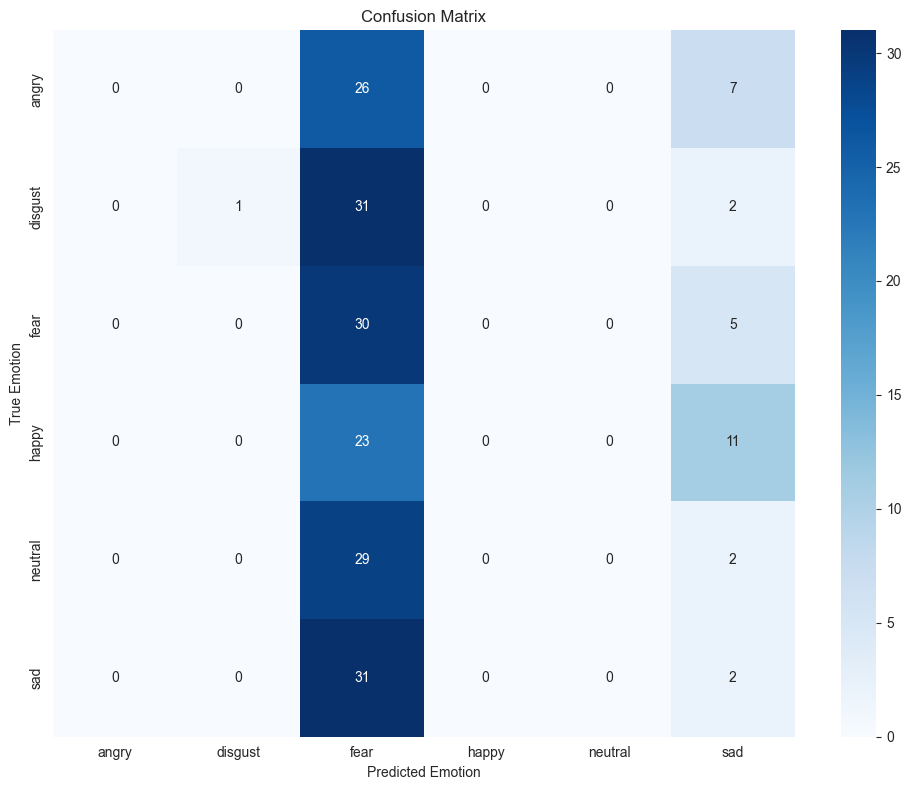

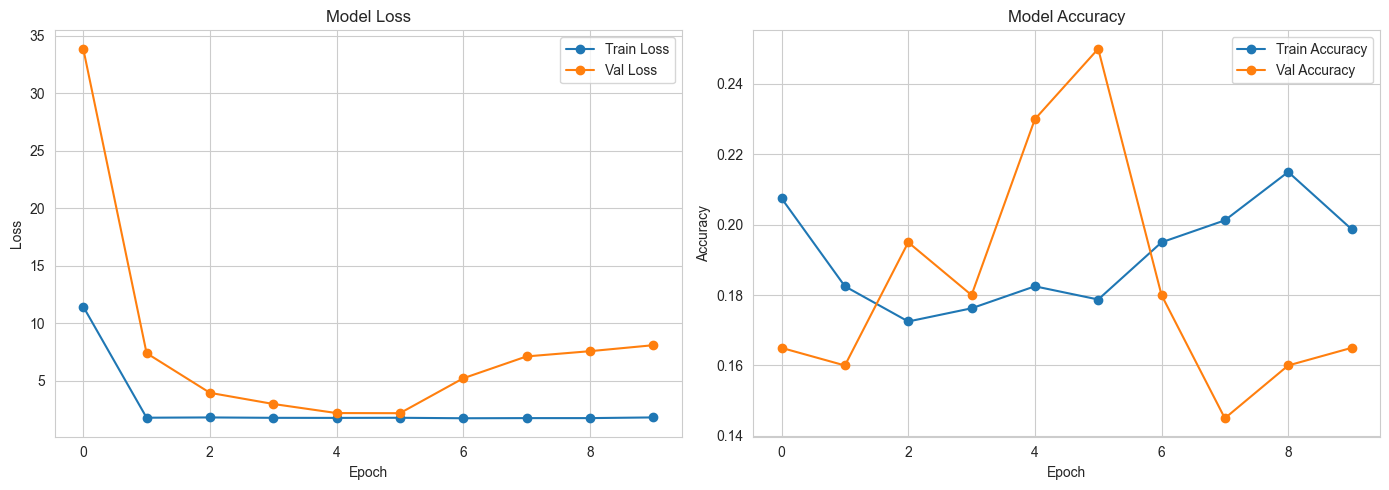

In [ ]:
# Evaluate the model
print("Evaluating model...")

# Make predictions
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

print("\n" + "="*60)
print("Model Performance:")
print("="*60)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Emotion')
plt.xlabel('Predicted Emotion')
plt.tight_layout()
plt.show()

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', marker='o')
axes[0].plot(history.history['val_loss'], label='Val Loss', marker='o')
axes[0].set_title('Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
axes[1].set_title('Model Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 7. Save Model

In [ ]:
# Save the model
model_path = '../models/speech_emotion_model.h5'
model.save(model_path)
print(f"✓ Model saved to: {model_path}")

# Save label encoder and model info
import joblib

model_info = {
    'label_encoder': label_encoder,
    'emotion_classes': label_encoder.classes_.tolist(),
    'n_mels': 128,
    'duration': 3,
    'input_shape': X_train.shape[1:]
}

info_path = '../models/speech_emotion_info.pkl'
joblib.dump(model_info, info_path)
print(f"✓ Model info saved to: {info_path}")

print("\n" + "="*60)
print("Speech Emotion Recognition Model Complete!")
print("="*60)
print(f"Model architecture: CNN on Mel Spectrograms")
print(f"Emotions: {label_encoder.classes_.tolist()}")
print(f"Test accuracy: {accuracy:.2%}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

print("\n" + "="*60)
print("Example Usage:")
print("="*60)
print("""
# Load model and info
from tensorflow import keras
import joblib
import librosa
import numpy as np

model = keras.models.load_model('../models/speech_emotion_model.h5')
info = joblib.load('../models/speech_emotion_info.pkl')

# Process new audio file
audio_path = 'path/to/audio.wav'
y, sr = librosa.load(audio_path, duration=info['duration'])
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=info['n_mels'])
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
mel_spec_db = mel_spec_db[..., np.newaxis]
mel_spec_db = np.expand_dims(mel_spec_db, axis=0)

# Predict emotion
prediction = model.predict(mel_spec_db)
emotion_idx = np.argmax(prediction)
emotion = info['emotion_classes'][emotion_idx]
confidence = prediction[0][emotion_idx]

print(f"Detected emotion: {emotion} ({confidence:.2%} confidence)")
""")